# `StableSpectralElements.jl` - 2D linear advection example

In [17]:
using StableSpectralElements, OrdinaryDiffEq, Plots, Plots.PlotMeasures, TimerOutputs

## Define the physical problem

In [18]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period
CFL = 0.05

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)))
initial_data = InitialDataSine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters (energy-conservative scheme)

In [19]:
M = 4
p = 4
form = StandardForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(0.0))
ode_algorithm = CarpenterKennedy2N54();

## Set up a `NodalTensor` scheme on quadrilaterals of degree `p` with `M` edges in each direction on Legendre-Gauss quadrature rules

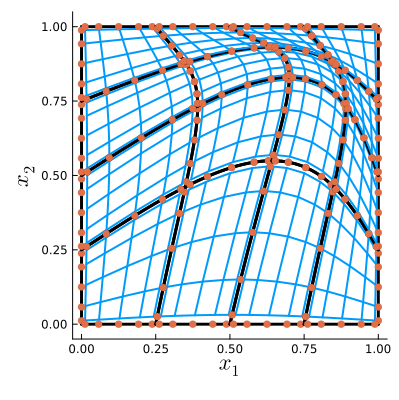

In [20]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Quad(), mapping_degree=p)

uniform_mesh = uniform_periodic_mesh(reference_approximation,
    ((0.0,L),(0.0,L)), (M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, 0.2, L)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
    "results/advection_2d/", overwrite=true, clear=true)

plot(spatial_discretization, grid_connect=true,fmt = :png)

## Run the solver

In [21]:
ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization, initial_data, form, (0.0, T))

h = L/sqrt(reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / a

reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false,
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*10))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            21.1s /  84.0%           7.75GiB /  88.4%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 du/dt                  2.84k    17.7s  100.0%  6.23ms   6.85GiB  100.0%  2.47MiB
   eval residual        2.84k    15.6s   88.0%  5.48ms   6.08GiB   88.7%  2.19MiB
   reconstruct noda...  2.84k    2.13s   12.0%   748μs    794MiB   11.3%   286KiB
 ────────────────────────────────────────────────────────────────────────────────


## Calculate the integral L<sup>2</sup> error norm

In [22]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)

L2 error:
0.036786552584907144


## Analyze conservation and energy dissipation

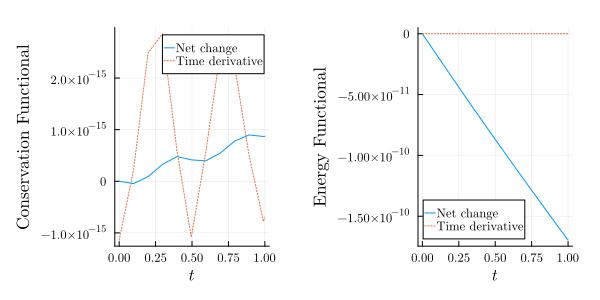

In [23]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), ylabel="Conservation Functional")
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), ylabel="Energy Functional")
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

## Postprocess for VTK visualization

In [24]:
postprocess_vtk(spatial_discretization, string(results_path,"solution.vtu"), last(sol.u));